<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/education_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教育スコア
- input
    - public_school_score.csv
        - 小学校スコア
        - 中学校スコア
    - library_score.csv
        - 図書館スコア
- output
    - education_score.csv
        - 教育スコア


In [1]:
!pip install -q japanize-matplotlib

     |████████████████████████████████| 4.1 MB 8.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '教育スコア'
output_score_file = 'education_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[[
    '地域ID', '市区町村名', '町名', '町丁目'
]].set_index('地域ID')
print(df_pop_master.shape)

(3145, 3)


### 学校スコア

In [7]:
df_school_score = pd.read_csv(os.path.join(DIR_NAME, 'public_school_score.csv'))[[
    '地域ID', '小学校スコア', '中学校スコア',
]].set_index('地域ID')
print(df_school_score.shape)

(3145, 2)


In [8]:
df_school_score.head()

,小学校スコア,中学校スコア
地域ID,,
101003,2.810,1.864
101004,2.524,1.879
101005,2.474,2.011
101007,2.601,2.207
101008,3.067,1.975


### 図書館

In [9]:
df_library_score = pd.read_csv(os.path.join(DIR_NAME, 'library_score.csv'))[[
    '地域ID', '図書館スコア'
]].set_index('地域ID')
print(df_library_score.shape)

(3145, 1)


In [10]:
df_library_score.head()

,図書館スコア
地域ID,
101003,1.74
101004,1.74
101005,1.93
101007,2.43
101008,2.37


In [11]:
import numpy as np
from scipy.stats import norm

def rank_score(sr_data):
    rank = sr_data.rank()
    count = rank.max() 
    x = (rank + 1)/(count + 1)
    max_val = 5
    y = norm.ppf(x, loc=0.5, scale=0.14)*max_val
    return np.clip(y, 0, max_val)

### 教育スコア

In [12]:
df_score = pd.concat([
    df_pop_master,
    df_school_score,
    df_library_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_pop_master)
df_pop_master = df_score

(3145, 6)


In [13]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 6)


,市区町村名,町名,町丁目,小学校スコア,中学校スコア,図書館スコア
地域ID,,,,,,
101003,千代田区,丸の内,丸の内１丁目,2.810,1.864,1.74
101004,千代田区,丸の内,丸の内２丁目,2.524,1.879,1.74
101005,千代田区,丸の内,丸の内３丁目,2.474,2.011,1.93
101007,千代田区,大手町,大手町１丁目,2.601,2.207,2.43
101008,千代田区,大手町,大手町２丁目,3.067,1.975,2.37


In [14]:
feature_list = {
    '小学校スコア': {'sort': 1, 'weight': 1},
    '中学校スコア': {'sort': 1, 'weight': 1},
    '図書館スコア': {'sort': 1, 'weight': 0.5},
}

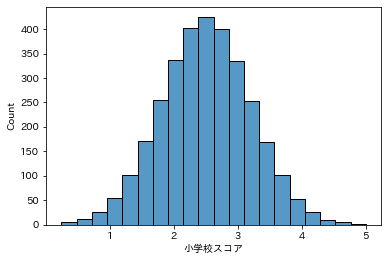

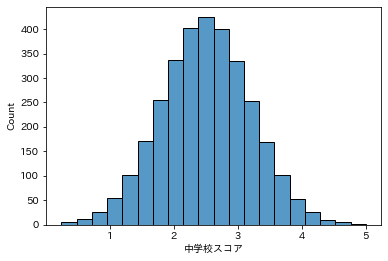

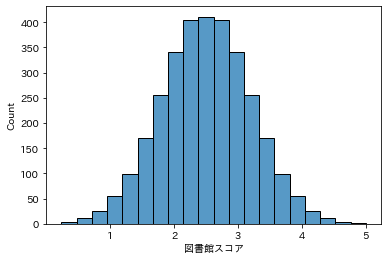

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [16]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

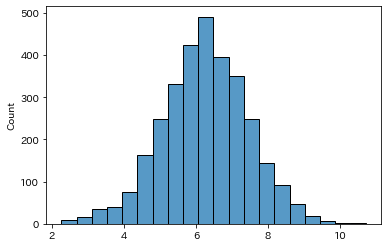

In [17]:
sns.histplot(_tmp_score, bins=20)
plt.show()

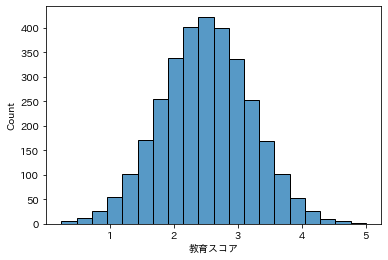

In [18]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [19]:
df_pop_master[score_name].describe()

count    3141.000000
mean        2.501557
std         0.698656
min         0.244613
25%         2.028908
50%         2.500558
75%         2.972493
max         5.000000
Name: 教育スコア, dtype: float64

In [20]:
df_pop_master[score_name] = df_pop_master[score_name].round(2)

In [21]:
df_pop_master[
    list(feature_list.keys()) + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True)

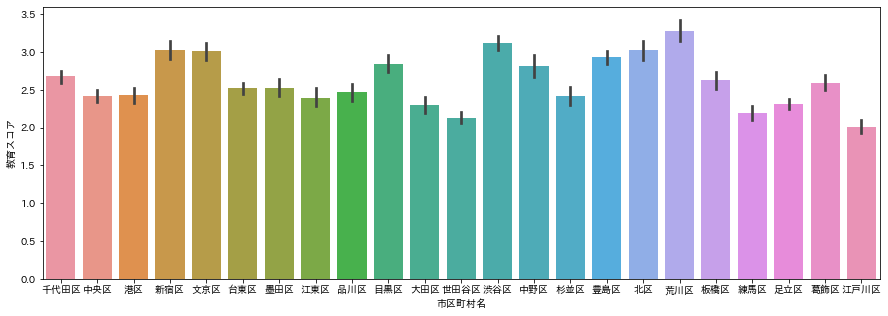

In [22]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [23]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + list(feature_list.keys()) + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(902, 7)


In [24]:
df_level.head(10)

,市区町村名,町名,町丁目,小学校スコア,中学校スコア,図書館スコア,教育スコア
0,新宿区,市谷山伏町,市谷山伏町,5.000,4.168,3.09,5.00
1,新宿区,北山伏町,北山伏町,4.410,4.410,3.14,4.89
2,中野区,鷺宮,鷺宮４丁目,3.669,5.000,3.02,4.76
3,新宿区,市谷甲良町,市谷甲良町,4.491,4.085,2.94,4.67
4,中野区,上鷺宮,上鷺宮１丁目,4.116,4.388,2.53,4.56
5,新宿区,南榎町,南榎町,4.198,4.092,2.95,4.52
6,新宿区,市谷柳町,市谷柳町,4.232,3.937,2.89,4.49
7,北区,田端,田端３丁目,3.714,3.709,4.37,4.46
8,北区,昭和町,昭和町３丁目,3.886,3.552,4.31,4.41
9,新宿区,原町,原町１丁目,4.124,3.878,2.86,4.37


In [25]:
df_level.tail(10)

,市区町村名,町名,町丁目,小学校スコア,中学校スコア,図書館スコア,教育スコア
892,杉並区,松庵,松庵２丁目,1.708,1.262,2.25,1.27
893,練馬区,上石神井南町,上石神井南町,1.300,1.691,2.06,1.24
894,品川区,東八潮,東八潮,1.854,1.536,0.82,1.15
895,世田谷区,砧公園,砧公園,0.922,1.431,1.77,0.92
896,大田区,城南島,城南島７丁目,1.353,1.470,0.73,0.90
897,練馬区,西大泉町,西大泉町,1.102,1.616,0.92,0.88
898,江戸川区,興宮町,興宮町,0.743,1.571,1.60,0.84
899,葛飾区,水元公園,水元公園,1.094,1.286,1.44,0.82
900,江東区,若洲,若洲１丁目,1.275,1.462,0.61,0.78
901,大田区,京浜島,京浜島１丁目,0.612,1.767,0.98,0.69
